Neural Network Classifier & Regressor

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

/tmp/ipykernel_43633/226299108.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


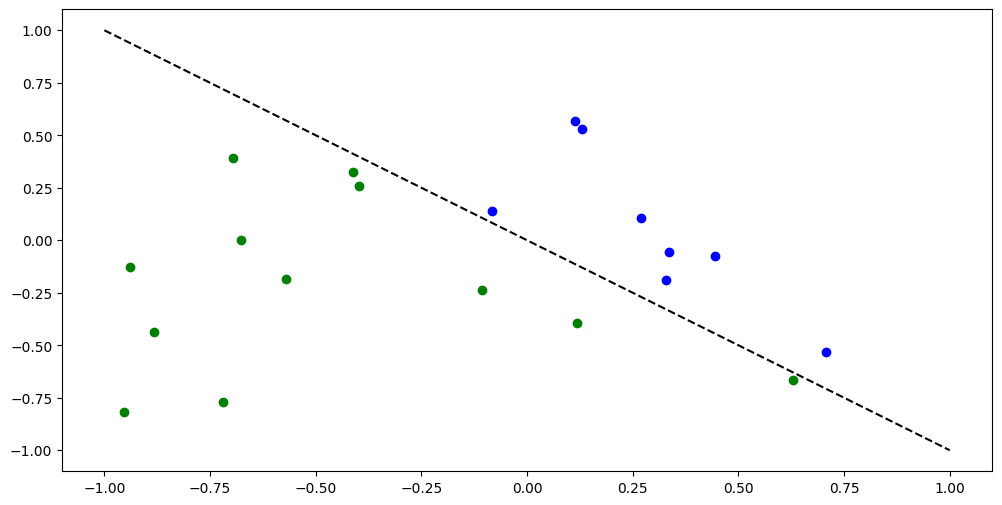

In [28]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [10]:
import pandas as pd

In [20]:
salary_dataset = pd.read_csv("/mnt/d/Documents/jamprograms/QC/QML-L/Quantum-ml/data/Salary_dataset.csv")
salary_dataset = salary_dataset.drop("Unnamed: 0", axis=1)
# salary_dataset.columns
salary_dataset.head()

,YearsExperience,Salary
0,1.2,39344.0
1,1.4,46206.0
2,1.6,37732.0
3,2.1,43526.0
4,2.3,39892.0


In [21]:
salary_dataset.columns

Index(['YearsExperience', 'Salary'], dtype='object')

In [23]:
salary_dataset.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.413333,76004.000000
std,2.837888,27414.429785
min,1.200000,37732.000000
25%,3.300000,56721.750000
50%,4.800000,65238.000000
75%,7.800000,100545.750000
max,10.600000,122392.000000


In [24]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
salary_dataset[['YearsExperience', 'Salary']] = scalar.fit_transform(salary_dataset[['YearsExperience', 'Salary']])

In [25]:
salary_dataset.tail()

,YearsExperience,Salary
25,0.840426,0.801453
26,0.893617,0.935956
27,0.904255,0.884763
28,0.978723,1.000000
29,1.000000,0.993870


In [26]:
from sklearn.model_selection import train_test_split

X = salary_dataset[['YearsExperience']]
y = salary_dataset['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Classification with an EstimatorQNN

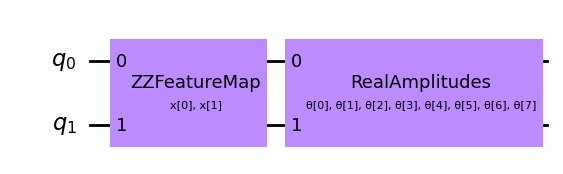

In [3]:
# construct QNN
qc = QuantumCircuit(2)
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

In [4]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

In [5]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [35]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=25), callback=callback_graph
)

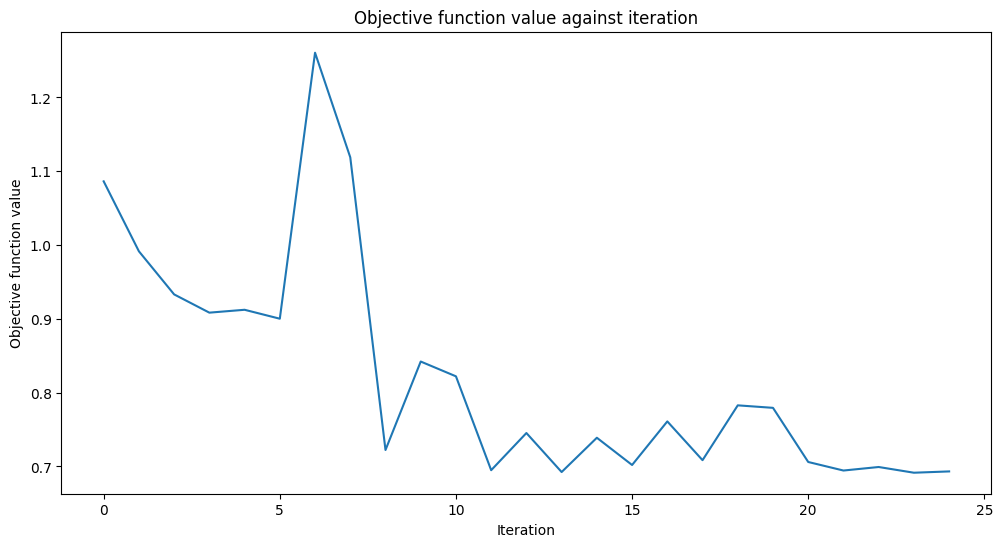

0.7

In [36]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

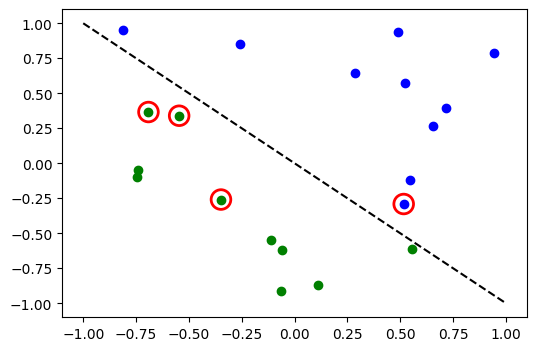

In [8]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [9]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

Classification with a SamplerQNN

Regression with an EstimatorQNN

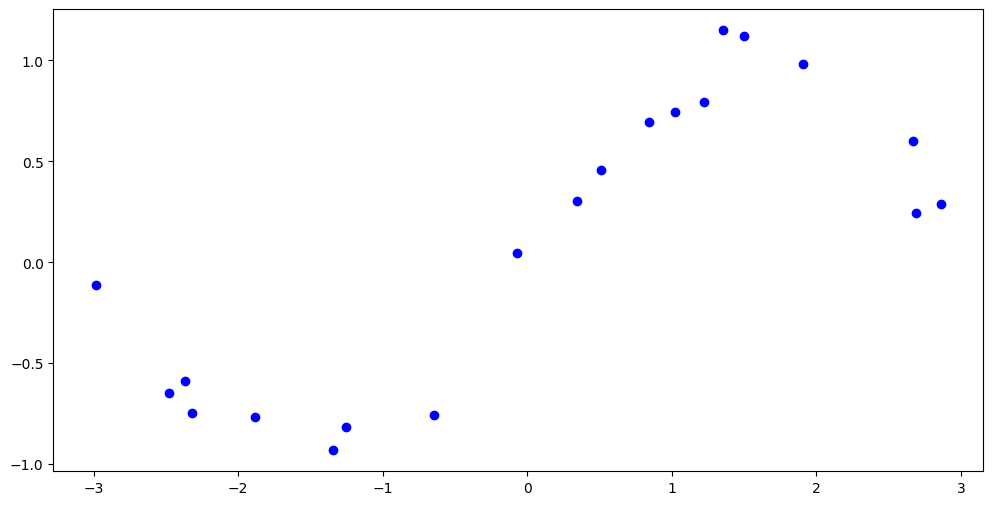

In [92]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

# plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [86]:
X.shape

(20, 1)

In [135]:
salary_dataset = pd.read_csv("/mnt/d/Documents/jamprograms/QC/QML-L/Quantum-ml/data/Salary_dataset.csv")
salary_dataset = salary_dataset.drop("Unnamed: 0", axis=1)
# salary_dataset.columns
salary_dataset.head()

,YearsExperience,Salary
0,1.2,39344.0
1,1.4,46206.0
2,1.6,37732.0
3,2.1,43526.0
4,2.3,39892.0


In [136]:
salary_dataset.columns

Index(['YearsExperience', 'Salary'], dtype='object')

In [137]:
salary_dataset.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.413333,76004.000000
std,2.837888,27414.429785
min,1.200000,37732.000000
25%,3.300000,56721.750000
50%,4.800000,65238.000000
75%,7.800000,100545.750000
max,10.600000,122392.000000


In [138]:
salary_dataset.shape

(30, 2)

In [159]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
salary_dataset[['YearsExperience', 'Salary']] = scalar.fit_transform(salary_dataset[['YearsExperience', 'Salary']])

In [139]:
salary_dataset.shape

(30, 2)

In [140]:
salary_dataset.tail()

,YearsExperience,Salary
25,9.1,105583.0
26,9.6,116970.0
27,9.7,112636.0
28,10.4,122392.0
29,10.6,121873.0


In [160]:
from sklearn.model_selection import train_test_split

X = salary_dataset[['YearsExperience']]
y = salary_dataset['Salary']

# X = X.to_numpy.reshape(-1, 1)
y = y.to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [152]:
X_test

,YearsExperience
27,0.904255
15,0.404255
23,0.755319
17,0.446809
8,0.223404
9,0.276596


In [ ]:
X_train


In [143]:
X_test.shape

(6, 1)

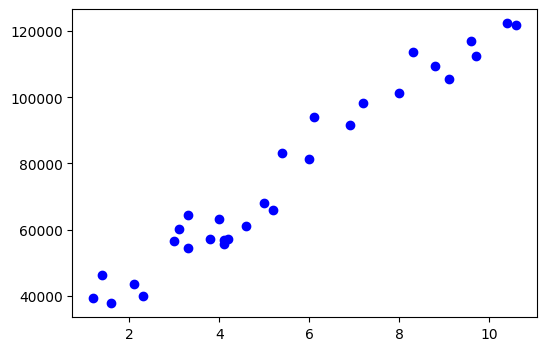

In [144]:
plt.plot(X, y, "bo")
plt.show()

In [161]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# construct QNN
regression_estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [162]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

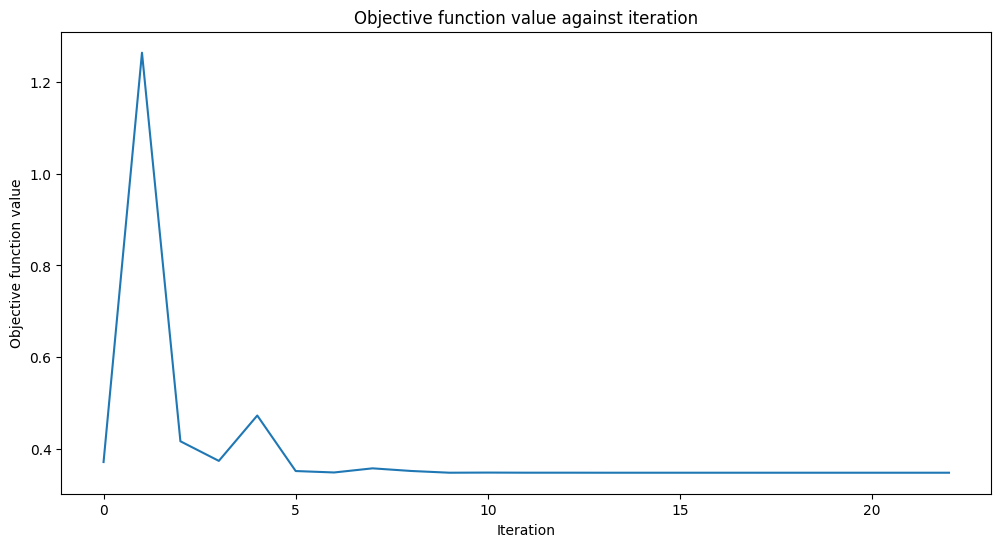

-2.2400360659810525

In [163]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X_train, y_train)
# regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X_test, y_test)

In [164]:
prediction = regressor.predict([9.6])
prediction

array([[-0.75994416]])